# Rotate vector velocities
Use covariance between horizontal & vertical velosities to rotate Vector velocities with vertical tilt sensors to E, N, U coordinates. Use coherence & phase of rotated velocities to verify rotation.

In [1]:
# Imports
import os
import glob
import numpy as np
from numpy.linalg import svd
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
# from mat73 import loadmat
from scipy.io import loadmat
from scipy import stats, signal
from sklearn.decomposition import PCA
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
mdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/mfiles'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Nortek Vector ADVs
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

C2 2022-07-13 13:00:00 - 2022-07-13 14:00:00
C2 First PCA: roll=0.36, pitch=179.89, head=123.71
C2 PCA: roll=0.36, pitch=179.89, head=123.71
C2 Vec: roll=-1.54, pitch=-2.85, head=124.28
R: [[-0.55500394  0.83183223  0.00507607]
 [ 0.83182366  0.55502396 -0.00421884]
 [-0.00632671  0.00188092 -0.99997822]], sums: [ 0.28190437  1.38262878 -1.004424  ], det=1.00
Flipping vertical velocity ... 
Flipping horizontal velocity ... 
 
C4 2022-07-13 13:00:00 - 2022-07-13 14:00:00
C4 First PCA: roll=-2.88, pitch=0.53, head=0.12
C4 PCA: roll=-2.88, pitch=0.53, head=0.12
C4 Vec: roll=-29.48, pitch=1.96, head=42.39
R: [[ 0.93287993  0.35776541 -0.0417007 ]
 [ 0.36008516 -0.92910323  0.08429635]
 [ 0.00858594  0.09365418  0.99556777]], sums: [ 1.24894464 -0.48472172  1.09780788], det=-1.00
 
C3 2022-07-13 13:00:00 - 2022-07-13 14:00:00
C3 First PCA: roll=5.89, pitch=-8.98, head=-92.65
C3 PCA: roll=5.89, pitch=-8.98, head=-92.65
C3 Vec: roll=-4.00, pitch=0.19, head=105.02
R: [[-0.04599118  0.98741889 

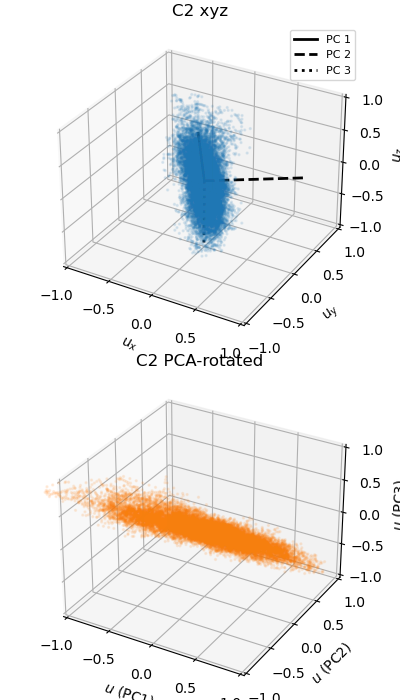

In [84]:
cs = ['#CADBC0', '#C94277']
servs = ['17212', '17371', '17219'] # Serial #s of Vectors
mids = ['C2', 'C4', 'C3'] # Mooring IDs
# Define expected headings in PCA coordinates for C2 & C3
heading_exp = {'C2': -125, 'C3': -90}
# Test time period
# t0 = pd.Timestamp('2022-07-14 18:00:00')
# t1 = pd.Timestamp('2022-07-14 19:00:00')
# t0 = pd.Timestamp('2022-07-17 14:00:00')
# t1 = pd.Timestamp('2022-07-17 15:00:00')
t0 = pd.Timestamp('2022-07-13 13:00:00')
t1 = pd.Timestamp('2022-07-13 14:00:00')

# Mooring ID to plot
midp = 'C2'
# Save PCA-rotated velocities in dict
pca_dict = {}
# Initialize comparison figure
fig, axes = plt.subplots(figsize=(4,7), nrows=2, subplot_kw={"projection": "3d"}, 
    constrained_layout=True)
lss = ['-', '--', ':'] # Linestyles for PC 1-3
# Iterate over Vectors, rotate C4 and plot comparison
for i, (mid, serv) in enumerate(zip(mids, servs)):
    print('{} {} - {}'.format(mid, t0, t1))
    # Netcdf dir.
    ncdir = os.path.join(vec_root, mid)
    # List all daily ncfiles
    fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
    # Read current date's file
    datestr = DT.strftime(t0, '%Y%m%d')
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, 
        datestr))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    # Get mean heading, pitch, roll angles
    head_ang = dsv.heading_ang.sel(time=slice(t0,t1)).copy()
    head_ang = np.rad2deg(np.pi*(head_ang-90)/180)
    head_mean = head_ang.mean(dim='time').item()
    pitch_ang = dsv.pitch_ang.sel(time=slice(t0,t1)).copy()
    pitch_mean = pitch_ang.mean(dim='time').item()
    roll_ang = dsv.roll_ang.sel(time=slice(t0,t1)).copy()
    roll_mean = roll_ang.mean(dim='time').item()
#     if mid == 'C4':
    # Get horizontal and vertical x,y,z velocities
    ux = dsv.uxd.sel(time=slice(t0, t1)).to_dataframe() # Convert to pandas
    ux = ux.interpolate(method='bfill').interpolate('ffill')
    ux -= ux.mean()
    uy = dsv.uyd.sel(time=slice(t0, t1)).to_dataframe() # Convert to pandas
    uy = uy.interpolate(method='bfill').interpolate('ffill')
    uy -= uy.mean()
    uz = dsv.uzd.sel(time=slice(t0, t1)).to_dataframe() # Convert to pandas
    uz = uz.interpolate(method='bfill').interpolate('ffill')
    uz -= uz.mean()
    # Rotate velocities based on principal axes
    vel_eul, R, eul = rpct.rotate_pca(ux=ux.values.squeeze(), 
                                      uy=uy.values.squeeze(), 
                                      uz=uz.values.squeeze(),
                                      return_r=True, 
                                      return_eul=True, 
                                      ) 
    # Check if R is left-handed (det(R)=-1) 
    if np.linalg.det(R) < 0 and mid in ['C2', 'C3']: 
        # Check if heading is off relative to expected heading
        if np.abs(heading_exp[mid] - np.rad2deg(eul['eul3'])) > 45:
            print('Flipping y axis ...')
            # Redo rotation, but flip y axis
            vel_eul, R, eul = rpct.rotate_pca(ux=ux.values.squeeze(), 
                                              uy=uy.values.squeeze(), 
                                              uz=uz.values.squeeze(),
                                              return_r=True, 
                                              return_eul=True, 
                                              flipy=True,
                                              ) 
    print('{} First PCA: roll={:.2f}, pitch={:.2f}, head={:.2f}'.format(
        mid, np.rad2deg(eul['eul2']), np.rad2deg(eul['eul1']), 
        np.rad2deg(eul['eul3'])))

    # Rotate using Euler angles
#     if mid == 'C4':
#         # Use all PCA axes for C4
#         vel_eul, R = rpct.rotate_euler(ux=ux.values.squeeze(), 
#                                        uy=uy.values.squeeze(), 
#                                        uz=uz.values.squeeze(),
#                                        eul1=eul['eul1'], 
#                                        eul2=eul['eul2'], 
#                                        eul3=eul['eul3'],
#                                       )
#     if mid in ['C2', 'C3']:
#         # Only use PCA heading for C2 and C3
#         vel_eul, R = rpct.rotate_euler(ux=ux.values.squeeze(), 
#                                        uy=uy.values.squeeze(), 
#                                        uz=uz.values.squeeze(),
#                                        eul1=np.deg2rad(pitch_mean), 
#                                        eul2=np.deg2rad(roll_mean), 
#                                        # eul1=eul['eul1'],
#                                        # eul2=eul['eul2'],
#                                        eul3=eul['eul3'],
#                                       )
    print('{} PCA: roll={:.2f}, pitch={:.2f}, head={:.2f}'.format(
        mid, np.rad2deg(eul['eul2']), np.rad2deg(eul['eul1']), 
        np.rad2deg(eul['eul3'])))
    print('{} Vec: roll={:.2f}, pitch={:.2f}, head={:.2f}'.format(
        mid, roll_mean, pitch_mean, head_mean))
    print('R: {}, sums: {}, det={:.2f}'.format(
        R, np.sum(R, axis=1), np.linalg.det(R)))
    # Compute the angle theta between x and z axes
    theta = np.arccos(np.dot(R[:,0], R[:,2]) / 
                     (np.linalg.norm(R[:,0]) * np.linalg.norm(R[:,2])))
    # Get velocity components
    up1 = vel_eul[:,0].copy()
    up2 = vel_eul[:,1].copy()
    up3 = vel_eul[:,2].copy()
    # Check if some component(s) need to be flipped
    if np.abs(np.rad2deg(eul['eul1'])) > 90:
        # z-axis points downward -> flip vertical velocity
        print('Flipping vertical velocity ... ')
        up3 *= (-1)
    if np.abs(np.rad2deg(eul['eul2'])) > 90:
        # z-axis points downward -> flip vertical velocity
        print('Flipping vertical velocity ... ')
        up3 *= (-1)
    # Check if heading is off if det(R) = 1
    if np.linalg.det(R) > 0 and mid in ['C2', 'C3']:
        if np.abs(heading_exp[mid] - np.rad2deg(eul['eul3'])) > 90:
            print('Flipping horizontal velocity ... ')
            up1 *= (-1)
    # Compute coherence and phase to check components
    spec_r = rpws.spec_uvz(z=up3, u=up1, v=up2, fs=16)
    # Get index of max. coherence^2 b/w ucs and uw
    ind_mcu = np.argmax((spec_r.coh_uz**2).sel(freq=slice(0.05, 0.3)).values).item()
    ind_mcv = np.argmax((spec_r.coh_vz**2).sel(freq=slice(0.05, 0.3)).values).item()
    # Compute ucs-uw phase at max coherence
    pmc = np.rad2deg(spec_r.ph_uz.sel(freq=slice(0.05, 0.3)).isel(freq=ind_mcu).item())
    # If phase is +90 -> flip ux velocity
    if pmc > 0:
        up1 *= (-1)
        # Compute coherence and phase again
        spec_r = rpws.spec_uvz(z=up3, u=up1, v=up2, fs=16)
    # Print ucs-uw phase at max coherence
    print('ucs-uw phase at max coh: {:.2f}'.format(pmc))
    
    print(' ')
    # Save to dict
    pca_dict['up1_{}'.format(mid)] = up1
    pca_dict['up2_{}'.format(mid)] = up2
    pca_dict['up3_{}'.format(mid)] = up3

    if mid == midp:
        # Plot unrotated points on first row
        axes[0].scatter(ux, uy, uz, s=2, color='C0', alpha=0.1)
        # Plot principal axes
        for ic, comp in enumerate(R):
            axes[0].plot([0, comp[0]],
                         [0, comp[1]],
                         [0, comp[2]],
                         label=f"PC {ic+1}",
                         linewidth=2,
                         linestyle=lss[ic],
                         color='k',
                         )
        axes[0].set_title('{} xyz'.format(mid))
        axes[0].set_xlabel(r'$u_x$')
        axes[0].set_ylabel(r'$u_y$')
        axes[0].set_zlabel(r'$u_z$')
        axes[0].legend(fontsize=8)
        # Rotated PCA points on second row
        axes[1].scatter(up1, up2, up3, s=2, color='C1', alpha=0.1)
        axes[1].set_title('{} PCA-rotated'.format(mid))
        axes[1].set_xlabel(r'$u$ (PC1)')
        axes[1].set_ylabel(r'$u$ (PC2)')
        axes[1].set_zlabel(r'$u$ (PC3)')

# Axis limits
for ax in axes.flat:
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])

plt.show()
# plt.close()



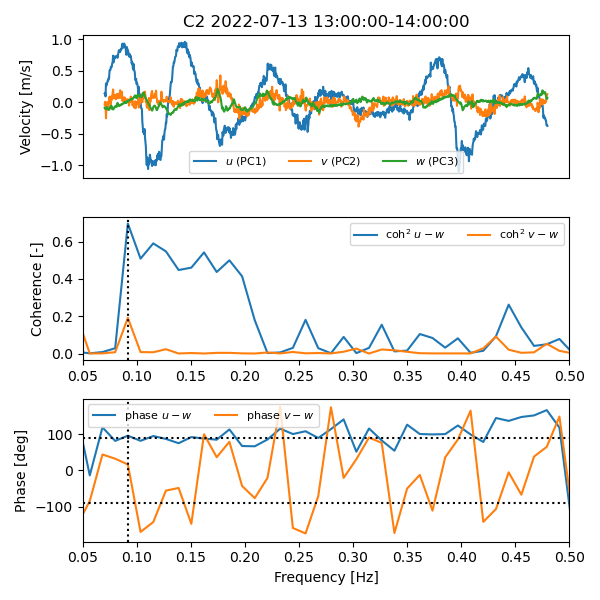

In [85]:
lss = ['-', '--']
mid = 'C2'
# Initialize comparison figure
fig, axes = plt.subplots(figsize=(6,6), nrows=3, sharex=False)
# Iterate over Vectors, rotate C4 and plot comparison
# Plot segments of velocity time series on top row
axes[0].plot(pca_dict['up1_{}'.format(mid)][:1000], color='C0', 
             label=r'$u$ (PC1)')
axes[0].plot(pca_dict['up2_{}'.format(mid)][:1000], color='C1',
             label=r'$v$ (PC2)')
axes[0].plot(pca_dict['up3_{}'.format(mid)][:1000], color='C2',
             label=r'$w$ (PC3)')
axes[0].set_xlabel(None)
axes[0].get_xaxis().set_visible(False)
# Coh. and phase are included in spectral dataset from rpws.spec_uvz()
spec_r = rpws.spec_uvz(z=pca_dict['up3_{}'.format(mid)], 
                       u=pca_dict['up1_{}'.format(mid)], 
                       v=pca_dict['up2_{}'.format(mid)], 
                       fs=16)
# Plot squared coherence as func of freq in middle row
(spec_r.coh_uz**2).plot(ax=axes[1], label=r'$\mathrm{coh}^2$ $u-w$', 
                        color='C0')
(spec_r.coh_vz**2).plot(ax=axes[1], label=r'$\mathrm{coh}^2$ $v-w$', 
                        color='C1')
# Plot phase as func of freq on second row
np.rad2deg(spec_r.ph_uz).plot(ax=axes[2], label=r'phase $u-w$', color='C0')
np.rad2deg(spec_r.ph_vz).plot(ax=axes[2], label=r'phase $v-w$', color='C1')
# Horizontal lines at phase = +/-90
axes[2].axhline(90, linestyle=':', color='k')
axes[2].axhline(-90, linestyle=':', color='k')
# Vertical line at max u-w coherence
ind_mc = (spec_r.coh_uz**2).sel(freq=slice(0.05, 0.3)).argmax().item()
axes[1].axvline(spec_r.freq.sel(freq=slice(0.05, 0.3)).values[ind_mc], color='k', linestyle=':')
axes[2].axvline(spec_r.freq.sel(freq=slice(0.05, 0.3)).values[ind_mc], color='k', linestyle=':')

# Axis limits etc
for ax in axes[1:]:
    ax.set_xlim([0.05, 0.5])
    ax.set_xlabel(None)
for ax in axes:
    ax.set_ylabel(None)
    ax.legend(fontsize=8, ncols=3)
axes[0].set_title('{} {}-{}'.format(mid, t0, t1.time()))
axes[2].set_xlabel('Frequency [Hz]')
axes[2].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('Velocity [m/s]')
axes[1].set_ylabel('Coherence [-]')
axes[2].set_ylabel('Phase [deg]')

plt.tight_layout()
plt.show()

In [69]:
stats.skew(pca_dict['up1_{}'.format('C3')])

-0.02635824185382796

Test rotation with Vector at C4, compare results agains Vector at C2 (good data).

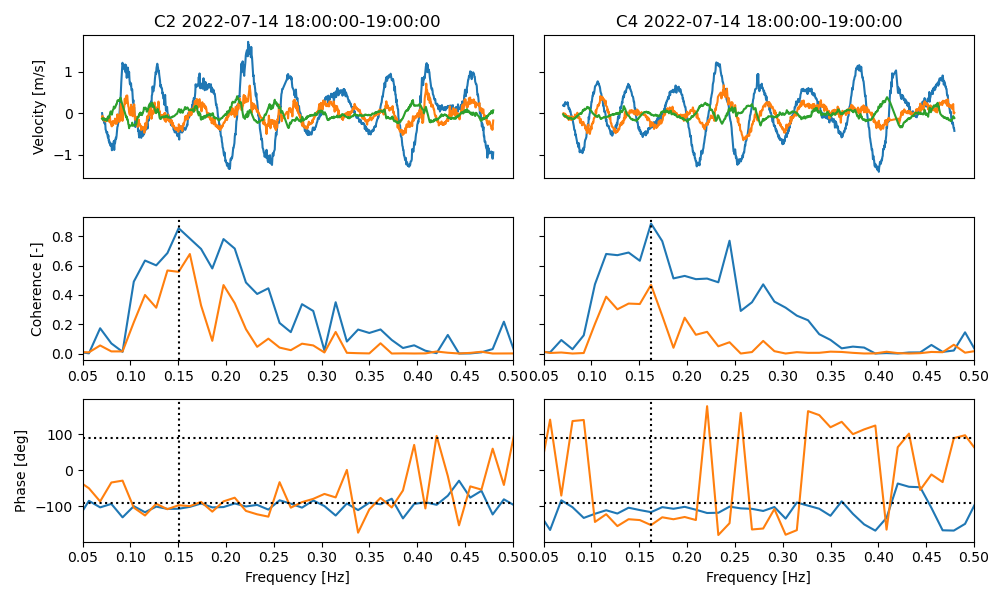

In [7]:
cs = ['#CADBC0', '#C94277']
servs = ['17212', '17371'] # Serial #s of Vectors
mids = ['C2', 'C4'] # Mooring IDs
# Test time period
t0 = pd.Timestamp('2022-07-14 18:00:00')
t1 = pd.Timestamp('2022-07-14 19:00:00')

lss = ['-', '--']
# Initialize comparison figure
fig, axes = plt.subplots(figsize=(10,6), nrows=3, ncols=2, sharey='row', sharex=False)
# Iterate over Vectors, rotate C4 and plot comparison
for i, (mid, serv) in enumerate(zip(mids, servs)):
    # Netcdf dir.
    ncdir = os.path.join(vec_root, mid)
    # List all daily ncfiles
    fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
    # Read current date's file
    datestr = DT.strftime(t0, '%Y%m%d')
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    if mid == 'C4':
        # Get horizontal and vertical x,y,z velocities
        ur = dsv.uxd.sel(time=slice(t0, t1))
        vr = dsv.uyd.sel(time=slice(t0, t1))
        wr = dsv.uzd.sel(time=slice(t0, t1))
        # Rotate velocities based on covariance
    elif mid == 'C2':
        ur = dsv.ucs.sel(time=slice(t0, t1))
        vr = dsv.uls.sel(time=slice(t0, t1))
        wr = dsv.uU.sel(time=slice(t0, t1))

    # Plot segments of velocity time series on top row
    ur.isel(time=slice(0, 1000)).plot(ax=axes[0,i], color='C0')
    vr.isel(time=slice(0, 1000)).plot(ax=axes[0,i], color='C1')
    wr.isel(time=slice(0, 1000)).plot(ax=axes[0,i], color='C2')
    axes[0,i].set_xlabel(None)
    axes[0,i].get_xaxis().set_visible(False)
    # Coh. and phase are included in spectral dataset from rpws.spec_uvz()
    spec_r = rpws.spec_uvz(z=wr.values, u=ur.values, v=vr.values, fs=16)
    # Plot squared coherence as func of freq in middle row
    (spec_r.coh_uz**2).plot(ax=axes[1,i], label='coh_uw**2', color='C0')
    (spec_r.coh_vz**2).plot(ax=axes[1,i], label='coh_vw**2', color='C1')
    # Plot phase as func of freq on second row
    np.rad2deg(spec_r.ph_uz).plot(ax=axes[2,i], label='ph_uw', color='C0')
    np.rad2deg(spec_r.ph_vz).plot(ax=axes[2,i], label='ph_vw', color='C1')
    # Horizontal lines at phase = +/-90
    axes[2,i].axhline(90, linestyle=':', color='k')
    axes[2,i].axhline(-90, linestyle=':', color='k')
    # Vertical line at max u-w coherence
    ind_mc = np.argmax((spec_r.coh_uz**2).values)
    axes[1,i].axvline(spec_r.freq.values[ind_mc], color='k', linestyle=':')
    axes[2,i].axvline(spec_r.freq.values[ind_mc], color='k', linestyle=':')


# Axis limits etc
for ax in axes[1:,:].flat:
    ax.set_xlim([0.05, 0.5])
    ax.set_xlabel(None)
for ax in axes[:,1].flat:
    ax.set_ylabel(None)
axes[0,0].set_title('C2 {}-{}'.format(t0, t1.time()))
axes[0,1].set_title('C4 {}-{}'.format(t0, t1.time()))


axes[2,0].set_xlabel('Frequency [Hz]')
axes[2,1].set_xlabel('Frequency [Hz]')
axes[0,0].set_ylabel('Velocity [m/s]')
axes[1,0].set_ylabel('Coherence [-]')
axes[2,0].set_ylabel('Phase [deg]')

plt.tight_layout()
plt.show()
# plt.close()





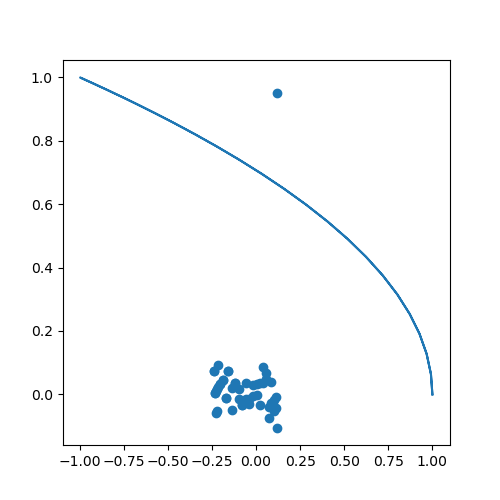

In [45]:
# Test
from sklearn.decomposition import PCA
x = np.linspace(0, 2*np.pi)
y = np.cos(x)
z = np.sin(x/2)

pca = PCA(n_components=2)
pca.fit(np.vstack([y,z]))
# print(pca.components_)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y,z)
ax.scatter(pca.components_[0], pca.components_[1])



